In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.feature_extraction import image

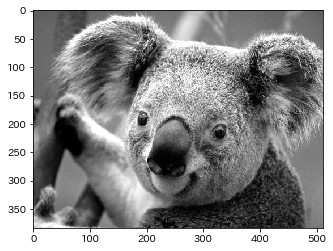

In [2]:
# read image
path = 'koala.png'
img = imageio.imread(path) 
plt.imshow(img, 'gray')

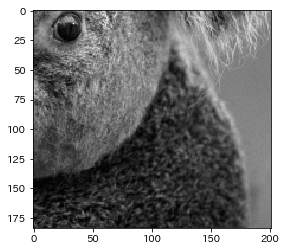

In [3]:
# crop_image
crop_h = 300
crop_w = 400
crop_size = 100
crop_img = img[crop_h - crop_size : crop_h+crop_size+1, crop_w-crop_size:crop_w+crop_size+1]
plt.imshow(crop_img, 'gray')

In [4]:
PATCH_WIDTH = 2 # patch width
PATCH_SIZE = PATCH_WIDTH * PATCH_WIDTH + 1 # patch size
ALPHA = 0.01 # hypter paramter
KNN_COUNT = 5 # neghborの数

In [5]:
# 一様分布に従うランダムな重みを作成
# この重みはpatchと同じサイズで中心ほど値が大きい正規分布に従う
# patchの重みの類似度を計算するときに中心ほど重みが大きくなるように計算する
axis = list(range(-PATCH_WIDTH, PATCH_WIDTH+1))
print(axis)
x, y = np.meshgrid(axis, axis) # axis×axisの格子状の点を作る
WEIGHT_DIST = norm.pdf(x) * norm.pdf(y) #　平均0分散1の正規分布を掛け合わせる
WEIGHT_DIST

[-2, -1, 0, 1, 2]


array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

In [6]:
# padding image
# おそらくpatchを探すときに探索範囲がpatch sizeで割り切れるための処理
pad_img = np.pad(crop_img, [PATCH_WIDTH, PATCH_WIDTH], 'symmetric')

print("crop image size: ", crop_img.shape)
print("padging image size: ", pad_img.shape)

HEIGHT, WIDTH = pad_img.shape
IMG_SIZE = HEIGHT*WIDTH
print("height: {}, width: {}".format(HEIGHT, WIDTH))

crop image size:  (184, 201)
padging image size:  (188, 205)
height: 188, width: 205


In [7]:
# patchを"全て"作成

PATCHES = image.extract_patches_2d(pad_img.T, (PATCH_SIZE, PATCH_SIZE))
# TODO
PATCHES = np.asarray([patch.T for patch in PATCHES]) # なんでてんち？
PATCH_COUNT = len(PATCHES)

print("patch shape: ", PATCHES.shape)
print("padding imageの大きさが{}x{}={}だから{}このpatchができる".format(HEIGHT,WIDTH,HEIGHT*WIDTH,PATCH_COUNT))



patch shape:  (36984, 5, 5)
padding imageの大きさが188x205=38540だから36984このpatchができる


In [8]:
# initilize offse　
# かく場所iに対して，-i〜SIZE-iのオフセットをKNN_COUNT分だけ作成
rand = (PATCH_COUNT-1) * np.random.rand(PATCH_COUNT, KNN_COUNT) # 画像サイズ*KNN_countの大きさの0-(PATCH_COUNT-1)の乱数の値をもつ行列を作成
tile = np.tile(np.arange(0, PATCH_COUNT), (KNN_COUNT, 1)).T # [[0,0,0,0,0],[1,1,1,1,1]...[38539, 38539, 38539, 38539, 38539]]
offsets = (rand - tile).astype(dtype=np.int)
offsets

array([[ 32470,  35216,  31841,  16978,  23307],
       [ 20218,  31278,  36769,  11448,   6747],
       [ 34424,  28232,  24422,  30064,   7812],
       ...,
       [-23656, -19380,  -4697, -14188,  -7324],
       [ -6650, -33481, -33182,  -3636, -36521],
       [-36906, -34854,  -7895, -28743, -34114]])

In [9]:
# initialize_weights
# 最初はランダムに選んだパッチで類似度を計算

# patchの類似度を計算
def patches_dissimilarity(patch1, patch2):
    diff = (patch1 - patch2) ** 2
    weighted_patch2 = diff * WEIGHT_DIST # diffを真ん中ほど大きい正規分布で重みずけ
    error = -ALPHA * diff.sum()
    return error

weights = np.ones([PATCH_COUNT, KNN_COUNT])
for i in range(PATCH_COUNT):
    patch = PATCHES[i]
    for j in range(KNN_COUNT):
        offset = offsets[i, j] # get random offset
        offset_patch = PATCHES[i + offset, :, :]
        weights[i, j] = patches_dissimilarity(patch, offset_patch)

weights

array([[-23.86, -22.4 , -29.27, -24.67, -28.12],
       [-26.  , -34.16, -21.54, -27.33, -26.54],
       [-27.05, -34.26, -25.39, -23.24, -21.26],
       ...,
       [-19.24, -36.61, -17.35, -26.28, -26.84],
       [-26.92, -19.21, -36.3 , -11.19, -17.97],
       [-22.39, -27.6 , -26.99, -30.28, -26.95]])

In [44]:
# inilize heap
## pythonのヒープ構造を扱う
## おそらく最大・最小値をすぐ取り出しするために用いられる

import heapq

# heapには重みとoffsetが記載してある．つまりあるpatchに対して，そのindex(offset)との類似度が示してある
ALL_HEAP = []
for i in range(PATCH_COUNT):
    h = []
    for j in range(KNN_COUNT):
        heapq.heappush(h, (weights[i, j], offsets[i, j]))
    
    ALL_HEAP.append(h)
        
ALL_HEAP

[[(-29.27, 31841),
  (-28.12, 23307),
  (-23.86, 32470),
  (-22.400000000000002, 35216),
  (-24.67, 16978)],
 [(-34.160000000000004, 31278),
  (-27.330000000000002, 11448),
  (-21.54, 36769),
  (-26.0, 20218),
  (-26.54, 6747)],
 [(-34.26, 28232),
  (-27.05, 34424),
  (-25.39, 24422),
  (-23.240000000000002, 30064),
  (-21.26, 7812)],
 [(-29.37, 32032),
  (-24.84, 13357),
  (-24.69, 35347),
  (-21.01, 35030),
  (-22.07, 2406)],
 [(-31.5, 26424),
  (-31.310000000000002, 26869),
  (-26.330000000000002, 1121),
  (-24.5, 10483),
  (-27.7, 36010)],
 [(-27.97, 25564),
  (-26.79, 1419),
  (-21.43, 22659),
  (-18.41, 27822),
  (-23.38, 36087)],
 [(-34.62, 26488),
  (-28.05, 36906),
  (-25.93, 10818),
  (-17.7, 10115),
  (-22.73, 27686)],
 [(-30.13, 14567),
  (-26.52, 9623),
  (-29.52, 1116),
  (-25.82, 6973),
  (-21.3, 5149)],
 [(-27.68, 36786),
  (-27.22, 2492),
  (-21.22, 3722),
  (-19.82, 14086),
  (-22.98, 9135)],
 [(-34.44, 21082),
  (-32.730000000000004, 14155),
  (-30.36, 29212),
  (-25

In [45]:
# import copy
# all_heap = copy.copy(ALL_HEAP)
ALL_HEAP = copy.copy(all_heap)
ALL_HE

In [54]:
# heapを新しくする

# 1-Dのindexをpositionにする
def idx2pos(idx):
    height = idx//HEIGHT
    width = idx//WIDTH
    return height, width
    
# 2-Dのpostionを1-Dのidxにする
def pix2idx(height, width):
    return HEIGHT*height+width

def update_heap(idx, other_idx):
    patch = PATCHES[idx, :, :]
    heap = ALL_HEAP[idx]
    other_heap = ALL_HEAP[other_idx]
    
    for k in range(KNN_COUNT):
        other_offset = other_heap[k][1] 
        print(other_heap)

        new_idx = idx + other_offset # idx_1に違うoffsetをたす
        new_idx = np.maximum(new_idx, 0) # new_idxが溢れないように調整
        new_idx = np.minimum(new_idx, PATCH_COUNT-1) # new_idxが溢れないように調整
        new_offset = new_idx - idx # new_idxが溢れていた時のために再計算

        new_patch = PATCHES[new_idx, :, :] # 新しいpatch
        new_weight = patches_dissimilarity(patch, new_patch) # new weight

        max_weight = heap[0][0] # heap構造は頂点が最大値となる
        if max_weight < new_weight:
            heapq.heapreplace(heap, (new_weight, new_offset))
            
    return heap

pix_shift = -1 # shift量？

for h in range(1, HEIGHT):
    for w in range(1, WIDTH):
        idx = pix2idx(h, w)
        height_shift_idx = pix2idx(h+pix_shift, w) # hegihtを少しshfit
        width_shift_idx = pix2idx(h, w+pix_shift) # widthを少しshfit
        
        ALL_HEAP[idx] = update_heap(idx, height_shift_idx) # もしheapがよくなれば新しくなって帰ってくる
        ALL_HEAP[idx] = update_heap(idx, width_shift_idx) # もしheapがよくなれば新しくなって帰ってくる
    
ALL_HEAP

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]
[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0

KeyboardInterrupt: 

In [ ]:
# random_search
n = PATCH_COUNT # ? IMG_COUNT
new_heaps = []
for idx in range(PATCH_COUNT):
    heap = ALL_HEAP[idx]
    new_heap = search_around(idx, heap)
    new_heaps.append(new_heap)

In [13]:
# search_around
L = 30 # hypter paramter
l = 0.5 # hypter parameter
q_range = np.arange(0, 3) # hypter paramter
cand_offsets = np.empty(())

for q in range(0, 3):
    

In [ ]:
# bulid new offsets
new_offsets = np.zeros(KNN_COUNT)

for k in range(KNN_COUNT):
    

In [ ]:
def build_new_offsets(idx, heap0, L, l, q, M, N):
    new_offsets = zeros(len(heap0))
    for k in range(0, len(heap0)):
        idx2 = int(idx) + int(heap0[k][1])
        [i2, j2] = idx1d_to_idx2d(idx2, M, N)
        [u, v] = (L*l**q)*(2*random.rand(2,) -1)
        [i3, j3] = array([i2, j2]) + array([u, v])
        i3 = int(i3)
        j3 = int(j3)
        i3 = max(0, i3)
        i3 = min(M, i3)
        j3 = max(0, j3)
        j3 = min(N, j3)
        idx3 = idx2d_to_idx1d(i3, j3, M, N)
        new_offsets[k] = idx3 - idx
    return new_offsets

In [16]:
ALL_HEAP[2]

[(-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0), (-0.0, 0)]

In [ ]:
def search_around(idx, heap0, patches, M, N, alpha, g):
    L = 30
    l= 0.5
    q_range = arange(0, 3)
    cand_offsets = empty((q_range.shape[0], len(heap0)))
    c = 0
    for q in q_range:
        cand_offsets[c,] = build_new_offsets(idx, heap0, L, l, q, M, N)
        c = c+1
    for c in range(0,3):
        heap1 = []
        for k in range(0, len(heap0)):
            heap1.append((0, cand_offsets[c, k]))
        new_heap0 =  try_improve_a_from_b(idx, idx, heap0, 
                                          heap1, patches,
                                          M, N, alpha, g)
    return new_heap0